# Homework 5

In this homework, you'll review some linear algebra, and practice using `scipy.optimize` to solve several variations of linear models.  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.optimize as opt

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but in our discussion (and codes) we will replace $\beta$ with `b`
```
y = X * b + eps.
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features (so it is an $n\times p$ matrix).  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with variance `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  One way to do this is to minimize the mean square error

\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}

The solution to this is the solution to the least squares problem
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (30 points)

There are a variety of ways to solve the above problem.  We will assume that $n > p$, meaning there are more observations than features.

### Part A: Generating Data (5 points)

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well. 


In [3]:
def gen_lstsq(n,p,sig = 0.1):
    """
    This generate a random least square problem with noise.
    
    Inputs
    -----------------
    n: number of observations
        type: int
    p: number of parameters
        type: int
    sig: amplitude of noise
        type: float
        
    Requirements
    ------------------------
    n > p, both n,p are positive real integers
    sig >= 0
    
    Output
    ------------------------
    X: random design matrix
        type: ndarray
    y: solution to system
        type: ndarray
    b: random parameters
        type: ndarray
    """
    X = np.random.randn(n,p)
    b = np.random.randn(p)
    y = np.dot(X,b)+sig * np.random.randn()
    return X,y,b

In [30]:
X,y,b = gen_lstsq(10,5)
print("X is{}".format(X))
print("y is{}".format(y))
print("b is{}".format(b))

X is[[-1.07937603 -0.88535916  0.77453597 -0.46605247  0.82066191]
 [-1.0542678   0.88875856 -0.07005032 -0.53718857  1.11062593]
 [ 1.11848783  0.83166108 -0.7331085  -0.14439108  1.13960047]
 [-1.5268034   1.20172478  0.21099864  2.14547292  0.50557583]
 [ 0.5152186   0.1368822  -0.70200071  1.00775338  0.98745395]
 [-0.88709248  1.31457375 -1.42647159 -0.12025787 -0.34338162]
 [-1.87569337  0.1993357   0.26496183  0.27813348  0.75956919]
 [ 1.21063487 -0.54393782  1.22179642  1.72060262  1.60829131]
 [ 0.19891056  1.29016381  0.35959576  1.05579827  3.12615561]
 [-0.60136092 -0.20363069 -1.32979967 -2.19960518  0.77771534]]
y is[ 0.7696032   0.53027801 -0.36956393  4.43897317  1.94197875  0.23572293
  2.2929559   2.6786996   3.15154995 -2.00552649]
b is[-0.77400254 -0.27793638 -0.22016767  1.52862167  0.67591178]


### Part B: QR factorization (3 points)

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above. 

In [4]:
def solve_lstsq_qr(X,y):
    """
    This function returns the parameters with design matrix and responces, using QR factorization.
    
    Inputs
    -----------------------
    X: design matrix
        type: ndarray
    y: responce to system
        type: ndarray
        
    Requirements
    ------------------------
    If X is n x p, then
    n > p, both n,p are positive real integers
    and y is n x 1.
    
    Output
    ------------------------
    b: parameters
        type: ndarray
    """
    q, r = np.linalg.qr(X)
    b = (np.linalg.inv(r)@ np.transpose(q)) @ y
    return b


In [6]:
h = solve_lstsq_qr(X,y)
print(np.linalg.norm(h-b))
print("Not very small difference due to noise, but small enough to see it's functioning.")

0.15370871262253585
Not very small difference due to noise, but small enough to see it's functioning.


In [7]:
n=100
p=50
X,y,b = gen_lstsq(100,50)
h = solve_lstsq_qr(X,y)
Jf = (2/n)*np.transpose(h)@(np.transpose(X) @ X)- (2/n)*np.transpose(y)@ X
Jf.shape
bh = (1/n)*(np.linalg.norm(np.matmul(X, b)-y)**2)
type(Jf)
Jf.shape

(1, 50)

### Part C: Normal Equations (3 points)

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above. Note that forming the full inverse might be a little slow. Instead, you could try to apply $(X^TX)^{-1}$ by forming an LU or Cholesky factorization instead (see the Linear Algebra section of the course book or the documentation for some examples).

In [8]:
def solve_lstsq_normal(X,y):
    """
    This function returns the parameters with design matrix and responces, using the normal equation.
    
    Inputs
    -----------------------
    X: design matrix
        type: ndarray
    y: responce to system
        type: ndarray
        
    Requirements
    ------------------------
    If X is n x p, then
    n > p, both n,p are positive real integers
    and y is n x 1.
    
    Output
    ------------------------
    b: parameters
        type: ndarray
    """
    XT = np.transpose(X)
    P, L, U = la.lu( XT @ X )
    b = ((np.linalg.inv(U)@ np.linalg.inv(L))@ np.transpose(P))@ XT@ y
    return b

In [9]:
h = solve_lstsq_normal(X,y)
print(np.linalg.norm(h-b))
print("Not very small difference due to noise, but small enough to see it's functioning.")

0.0703438017249215
Not very small difference due to noise, but small enough to see it's functioning.


### Part D: Check Your Work (3 points)

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

In [23]:
X,y,b = gen_lstsq(100,50)
h1 = solve_lstsq_qr(X,y)
h2 = solve_lstsq_normal(X,y)
diff = np.linalg.norm(h1-h2)
print("difference between two method's solution is {}".format(diff))
h3, res, rnk, s = la.lstsq(X,y)
diff2 = np.linalg.norm(h1-h3)
print("difference between the created method's solution and scipy lsq is {}".format(diff2))

difference between two method's solution is 1.17430032258397e-14
difference between the created method's solution and scipy lsq is 1.2011022911444407e-14


### Part E: Estimate the Error (6 points)

Write a function `err` which estimates the error in your fit using the equation $\frac{1}{n}\|X * \hat{b} - y\|_2^2$. The function should have the call signature `err(X,y,bhat).` 

Create a plot of the error vs the noise parameter `sig` (i.e. use your code from the previous parts to generate $y,$ $\hat{b},$ and $X$ for various $\sigma \in[10^{-4},10]$ and use `err` to compute the corresponding error).  Use `n=100`, `p=50` when generating data.  Put your plot on log-log axes.  Give it a title and axis labels.

As above, you should generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)`. Note: when choosing `sig` on $[10^{-4},10]$ it would help if you gave them a logarithmic distribution (like taking equispaced points $t_0,\dots,t_N$ between -4 and 1, and setting $\sigma_0 =10^{t_0},\dots, \sigma_N = 10^{t_n}.$

(Optional) Try to make smoother plots by averaging the error over several trials.


In [10]:
def err(X,y,bhat):
    """
    This function returns the error in my fitting using equation above.
    
    Inputs
    -----------------------
    X: design matrix
        type: ndarray
    y: responce to system
        type: ndarray
    bhat: estimated parameters
        type: ndarray
        
    Requirements
    ------------------------
    If X is n x p, then
    n > p, both n,p are positive real integers
    and y is n x 1.
    
    Output
    ------------------------
    error: error of parameter and real response
        type: float
    """
    n,p = X.shape
    error = (1/n)*(np.linalg.norm(np.matmul(X, bhat)-y)**2)
    return error

In [11]:
n = 100
p = 50
trial = 100
sig_pow = np.linspace(-4,1,trial)
sig = 10**(sig_pow)

# now we create the list of errors corresponding to list of variance.
errl_qr = np.zeros(trial)
errl_normal = np.zeros(trial)
smooth_p = 20
for count in range(smooth_p):
    # This is to use more tries to make the plot smoother.
    errl_qr_temp = []
    errl_normal_temp = []
    for sig_ele in sig:
        X,y,b = gen_lstsq(n,p, sig_ele)
        
        bhat_qr = solve_lstsq_qr(X,y)
        err_qr = err(X,y,bhat_qr)
        errl_qr_temp.append(err_qr)

        bhat_normal = solve_lstsq_normal(X,y)
        err_normal = err(X,y,bhat_normal)
        errl_normal_temp.append(err_normal)
        
    errl_qr = np.add(errl_qr, errl_qr_temp)
    errl_normal = np.add(errl_normal, errl_normal_temp)
    
errl_qr = np.divide(errl_qr, smooth_p)
errl_normal = np.divide(errl_normal, smooth_p)

Text(0.5, 1.0, 'normal method error - sigma plot; smoothened')

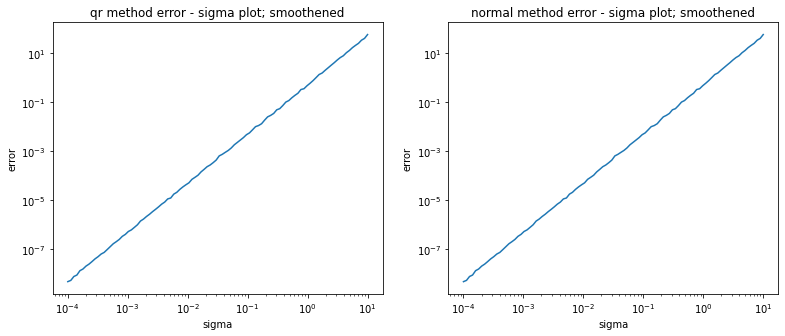

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))

ax[0].loglog(sig, errl_qr)
ax[0].set_xlabel("sigma")
ax[0].set_ylabel("error")
ax[0].set_title("qr method error - sigma plot; smoothened")

ax[1].loglog(sig, errl_normal)
ax[1].set_xlabel("sigma")
ax[1].set_ylabel("error")
ax[1].set_title("normal method error - sigma plot; smoothened")

### Part F: Discussion (3 points)

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations).

In [83]:
X,y,b = gen_lstsq(20,10)

print("For n = 20, p = 10, the QR method takes")
%timeit solve_lstsq_qr(X,y)

print("and the normal method takes")
%timeit solve_lstsq_normal(X,y)
print()

X,y,b = gen_lstsq(200,100)

print("For n = 200, p = 100, the QR method takes")
%timeit solve_lstsq_qr(X,y)

print("and the normal method takes")
%timeit solve_lstsq_normal(X,y)
print()

X,y,b = gen_lstsq(2000,1000)

print("For n = 2000, p = 1000, the QR method takes")
%timeit solve_lstsq_qr(X,y)

print("and the normal method takes")
%timeit solve_lstsq_normal(X,y)

For n = 20, p = 10, the QR method takes
57.2 µs ± 850 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
and the normal method takes
48.7 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

For n = 200, p = 100, the QR method takes
800 µs ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
and the normal method takes
706 µs ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

For n = 2000, p = 1000, the QR method takes
212 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
and the normal method takes
186 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


---

_your discussion here_

### Answer to discussion:
So we can see that in general, for different scales of design matrices, the normal method is always slightly faster.

This is because the qr method concerns with the computation of an inverse of $R$, whereas in the codes above we circumvented that for normal method with the use of LU factorization. 

The difference is not to big due to extra matrix multiplications in the normal method. And the fact that we're solving only one system.

### Part G: Optimization (5 points)

Solve the minimization problem 
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}

We might write the above expression as
\begin{equation}
n f(b) \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}

We can take a derivative with respect to $b_j$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}

Putting this in matrix form, we obtain
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [5]:
def solve_lstsq_opt(X, y):
    """
    This function finds the solution y using a minimization method.
    
    Inputs
    -----------------------
    X: design matrix
        type: ndarray
    y: responce to system
        type: ndarray
        
    Requirements
    ------------------------
    If X is n x p, then
    n > p, both n,p are positive real integers
    and y is n x 1.
    
    Jf: Jacobian matrix
        type: ndarray
        
    Jf is 1 x p.
    
    Output
    ------------------------
    b: parameters
        type: ndarray
    """
    n,p = X.shape
    to_min = lambda b : (1/n)*(np.power(la.norm(X @ b - y),2))
    Jf = lambda b : (2/n)*(b.T @ ( X.T @ X))- (2/n)*(np.transpose(y)@ X)
    sol = opt.minimize(to_min, x0 = np.random.rand(p),jac = Jf)
    
    # We'd like to do a little check about whether a minimum is reached.
    if sol.success:
        return sol.x
    else:
        print("The optimization is not successful, but still, the output is")
        return sol

#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

In [34]:
X,y,b = gen_lstsq(100,50)
h1 = solve_lstsq_qr(X,y)
h2 = solve_lstsq_normal(X,y)
h4 = solve_lstsq_opt(X, y)
diff = np.linalg.norm(h1-h4)
print("difference between qr method and minimization is {}".format(diff))
diff2 = np.linalg.norm(h2-h4)
print("difference between normal method and minimization is {}".format(diff2))

difference between qr method and minimization is 1.2469001001907925e-05
difference between normal method and minimization is 1.2469001005842327e-05


### Part H: Discussion (2 points)

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

In [6]:
X,y,b = gen_lstsq(20,10)

print("For n = 20, p = 10, the QR method takes")
%timeit solve_lstsq_qr(X,y)

print("and the minimization method takes")
%timeit solve_lstsq_opt(X,y)
print()

X,y,b = gen_lstsq(200,100)

print("For n = 200, p = 100, the QR method takes")
%timeit solve_lstsq_qr(X,y)

print("and the minimization method takes")
%timeit solve_lstsq_opt(X,y)
print()

X,y,b = gen_lstsq(2000,1000)

print("For n = 2000, p = 1000, the QR method takes")
%timeit solve_lstsq_qr(X,y)

print("and the minimization method takes")
%timeit solve_lstsq_opt(X,y)
print()

For n = 20, p = 10, the QR method takes
63.7 µs ± 2.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
and the minimization method takes
1.71 ms ± 21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

For n = 200, p = 100, the QR method takes
791 µs ± 55.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
and the minimization method takes
16.1 ms ± 673 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

For n = 2000, p = 1000, the QR method takes
198 ms ± 5.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
and the minimization method takes
3.75 s ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



---

THe minimization method is a lot slower. But that makes sense because we have to first compute the jacobian.

## Problem 1 - Ridge Regression (10 points)

We'll now turn to the problem of what to do when `n < p` (there are now fewer observations than features).  In this case we can find a $b$ which satisfies the equation $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

As we discussed in class, we can change the problem to try to make it unique. One simple way of doing this is to add an additional term to our optimization problem. Ridge regression is one such approach.

Ridge regression seeks to solve the following optimization problem:

\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}

$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Part A: Optimization (6 points)

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}

---

It's clear that we only need to add $2\lambda b^T$ in the expression of the Jacobian due to addition rule.

i.e.  $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X + 2\lambda b^T$.

In [148]:
def solve_ridge_opt(X, y, lam=0.1):
    """
    This function finds the solution y using a minimization method.
    
    Inputs
    -----------------------
    X: design matrix
        type: ndarray
    y: responce to system
        type: ndarray
    lam: parameter with respect to b
        type: float
        
    Requirements
    ------------------------
    If X is n x p, then
    n > p, both n,p are positive real integers
    and y is n x 1.
    
    Jf is 1 x p.
    
    Output
    ------------------------
    b: parameters
        type: ndarray
    Jf: Jacobian matrix
        type: ndarray
    """
    n,p = X.shape
    to_min = lambda b : float((1/n)*((np.linalg.norm(np.matmul(X, b)-y))**2)+lam*(np.linalg.norm(b)**2))
    Jf = lambda b : (2/n)*(np.transpose(b)@(np.transpose(X) @ X))- (2/n)*(np.transpose(y)@ X)+2*lam*np.transpose(b)
    sol = opt.minimize(to_min, x0 = np.random.randn(p,1),jac=Jf)
    
    # We'd like to do a little check about whether a minimum is reached.
    if sol.success:
        return sol.x
    else:
        print("The optimization is not successful, but still, the output is")
        return sol

In [149]:
x0 = np.random.randn(50,1)
x0.shape

(50, 1)

### Part B: Compute the error (4 points)

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the error of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2` (see Problem 0, Part E).  Use a `semilogx` plot.

In [150]:
X,y,b = gen_lstsq(50,100)
h5 = solve_ridge_opt(X, y)

In [151]:
n = 50
p = 100
trial = 100
lam_pow = np.linspace(-4,2,trial)
lam = 10**(lam_pow)

# now we create the list of errors corresponding to list of variance.
errl_ridge = np.zeros(trial)
smooth_p = 100
for count in range(smooth_p):
    # This is to use more tries to make the plot smoother.
    errl_ridge_temp = []
    for lam_ele in lam:
        X,y,b = gen_lstsq(n,p)
        
        bhat_ridge = solve_ridge_opt(X,y,lam_ele)
        err_ridge = err(X,y,bhat_ridge)
        # the error function is the same one as above, so we don'e implement it again.
        errl_ridge_temp.append(err_ridge)
        
    errl_ridge = np.add(errl_ridge, errl_ridge_temp)
    
errl_ridge = np.divide(errl_ridge, smooth_p)

Text(0.5, 1.0, 'ridge method error - lambda semilogx plot; smoothened')

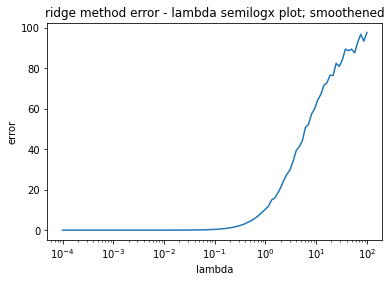

In [152]:
plt.semilogx(lam, errl_ridge)
plt.xlabel("lambda")
plt.ylabel("error")
plt.title("ridge method error - lambda semilogx plot; smoothened")

Text(0.5, 1.0, 'ridge method error - lambda loglog plot; smoothened')

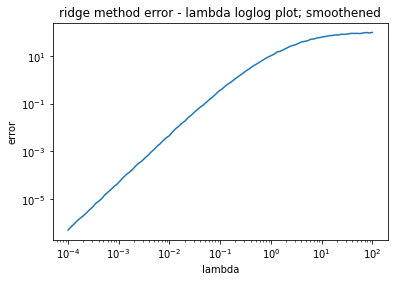

In [153]:
plt.loglog(lam, errl_ridge)
plt.xlabel("lambda")
plt.ylabel("error")
plt.title("ridge method error - lambda loglog plot; smoothened")

### Analysis (optional - no points)

Find an analytic expression for the true solution to the ridge regression problem in terms of $X,$ $\lambda,$ and $y.$

### SVD (optional - no points)

Use the SVD to solve $X*b = y.$ Do this by forming the SVD of $X = U\Sigma V^T.$ Set $b = V z$ where $V$ is the $p\times n$ matrix consisting of the first $n$ right singular vectors (why?). Then, the system you get is $U \Sigma z = y.$ You can solve it by applying $U^T$ to both sides (why?) and noting that $\Sigma$ is diagonal. 

Note that you should be using the version of the SVD which (for $n<p$ but $X$ having full rank) gives $U$ as an $n\times n$ matrix, $\Sigma$ as an $n\times n$ diagonal matrix, and $V$ as a $p \times n$ matrix.

## Problem 2 - Lasso (20 points)

The Lasso is L1-regularized regression.  This is often used when `p > n`, and when the parameter vector `b` is assumed to be sparse, meaning that it has few non-zero entries.

The minimization problem is
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Where again, $\lambda$ can be chosen.

### Part A: Generate Data (6 points)

We need to modify our generation of data to produce sparse `b`.  Write a function `gen_lstsq_sparse(n, p, sig=0.1, k=10)`, which generates `X` and `y` in the same way as `gen_lstsq`, but now `b` is generated to be a vector of length `p` with `k` random entries set to 1, and all other entries set to 0. Hint: look at `np.random.choice` for generating `k` random integers without replacement.

In [42]:
def gen_lstsq_sparse(n,p,sig = 0.1, k = 10):
    """
    This generate a random least square problem with noise.
    
    Inputs
    -----------------
    n: number of observations
        type: int
    p: number of parameters
        type: int
    sig: amplitude of noise
        type: float
    k: how many entries of b is nonempty(value=1)
        type: int
    
    Requirements
    ------------------------
    n < p, both n,p are positive real integers
    sig >= 0
    
    p>k
    
    Output
    ------------------------
    X: random design matrix
        type: ndarray
    y: solution to system
        type: ndarray
    b: random parameters
        type: ndarray
    """
    X = np.random.randn(n,p)
    b = np.zeros(p)
    nonzerolist = np.random.choice(p, k, replace=False)
    for i in nonzerolist:
        b[i] = 1
    y = np.dot(X,b)+sig * np.random.randn()
    return X,y,b

In [92]:
X,y,b = gen_lstsq_sparse(50,100)
(np.linalg.norm(b,1))
jf = (2/n)*(b @(np.transpose(X) @ X))- (2/n)*(np.transpose(y)@ X)+lam*(np.sign(b.T))
jf.shape

(100,)

### Part B: Optimization (10 points)

Recall we want to find `bhat` to solve
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_lasso_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
\begin{equation}
\lambda \|b\|_1 = \lambda \sum_i |b_i|
\end{equation}

If $b_i$ is zero, then take $\partial_i |b_i| = 0$ (this is in the [subgradient](https://en.wikipedia.org/wiki/Subderivative)). Hint 2: look at `np.sign` for implementation

---

The expression is just to add $\lambda*sign(b^T)$.

i.e. $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X + \lambda*sign(b^T)$.

But if we use our gen_lstsq_lasso method, the out put $b = sign(b)$! So we are good to just use b to make it faster.

In [154]:
def solve_lasso_opt(X, y, lam=0.1):
    """
    This function finds the solution y using a minimization method.
    
    Inputs
    -----------------------
    X: design matrix
        type: ndarray
    y: responce to system
        type: ndarray
    lam: parameter with respect to b
        type: float
        
    Requirements
    ------------------------
    If X is n x p, then
    n > p, both n,p are positive real integers
    and y is n x 1.
    
    Jf is 1 x p.
    
    Output
    ------------------------
    b: parameters
        type: ndarray
    Jf: Jacobian matrix
        type: ndarray
    """
    n,p = X.shape
    to_min = lambda b : float((1/n)*((np.linalg.norm(np.matmul(X, b)-y))**2)+lam*(np.linalg.norm(b,1)))
    Jf = lambda b : (2/n)*(b @(np.transpose(X) @ X))- (2/n)*(np.transpose(y)@ X)+lam*b
    sol = opt.minimize(to_min, x0 = np.random.randn(p),jac=Jf,tol=1e-4)
    # the tolerance of the matrix needs to be larger, otherwise it always says doesn't converge.
    
    # We'd like to do a little check about whether a minimum is reached.
    if sol.success:
        return sol.x
    else:
        return sol.x

In [155]:
X,y,b = gen_lstsq_sparse(50,100)
print(np.linalg.norm(b-np.sign(b)))

0.0


### Part C: Compute the Error (4 points)

Set `n = 50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  Make a plot that displays the error of `bhat` computed using `solve_lasso_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

In [156]:
n = 50
p = 100
trial = 100
lam_pow = np.linspace(-4,2,trial)
lam = 10**(lam_pow)

# now we create the list of errors corresponding to list of variance.
errl_lasso = np.zeros(trial)
smooth_p = 100
for count in range(smooth_p):
    # This is to use more tries to make the plot smoother.
    errl_lasso_temp = []
    for lam_ele in lam:
        X,y,b = gen_lstsq_sparse(n,p)
        bhat_lasso = solve_lasso_opt(X,y,lam = lam_ele)
        np.matmul(X, bhat_lasso)
        err_lasso = err( X , y , bhat_lasso)
        # the error function is the same one as above, so we don'e implement it again.
        errl_lasso_temp.append(err_lasso)
        
    errl_lasso = np.add(errl_lasso, errl_lasso_temp)
    
errl_lasso = np.divide(errl_lasso, smooth_p)

After checking, even though the optimization does not converge, the result we get below is already good enough. It means only a matter of tolerance is affecting the rsult. 

Text(0.5, 1.0, 'lasso method error - lambda semilogx plot; smoothened')

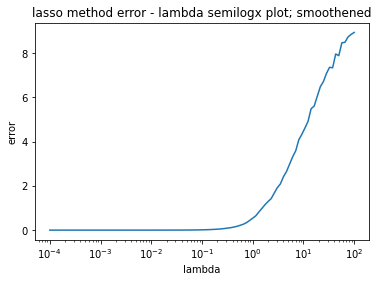

In [157]:
plt.semilogx(lam, errl_lasso)
plt.xlabel("lambda")
plt.ylabel("error")
plt.title("lasso method error - lambda semilogx plot; smoothened")

Text(0.5, 1.0, 'lasso method error - lambda loglog plot; smoothened')

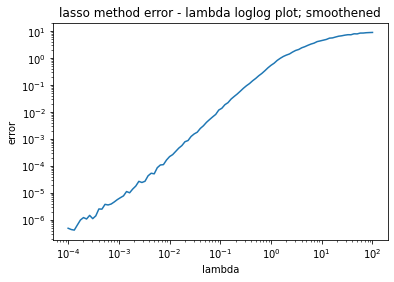

In [158]:
plt.loglog(lam, errl_lasso)
plt.xlabel("lambda")
plt.ylabel("error")
plt.title("lasso method error - lambda loglog plot; smoothened")